In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import gcm_filters

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data
from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

# Pulling up merged atmos/ocean dataset
### Question: Should I use all the atmos and ocean vars I have access to?

In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Filtering with gcm-filters Attempt

In [3]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_in

<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [6]:
print("Filtering model")
ds_out = filter_inputs_dataset(ds_in, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
ds_out

Filtering model


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [4]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/8787/status,
Dashboard: /user/panalluri/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42547,Workers: 4
Dashboard: /user/panalluri/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:39499,Total threads: 2
Dashboard: /user/panalluri/proxy/42169/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:35897,


## Drake Passage case

In [7]:
variables = ["slp", "v_ref", "u_ref", "t_ref", "q_ref", "wind", "rh_ref", 
             "surface_temp", "u_ocean", "v_ocean", "u_relative", "v_relative"]

data_high_res = ds_in.isel(time=0, xt_ocean=slice(2000,2200), yt_ocean=slice(500,550))
data_low_res = ds_out.isel(time=0, xt_ocean=slice(2000,2200), yt_ocean=slice(500,550))

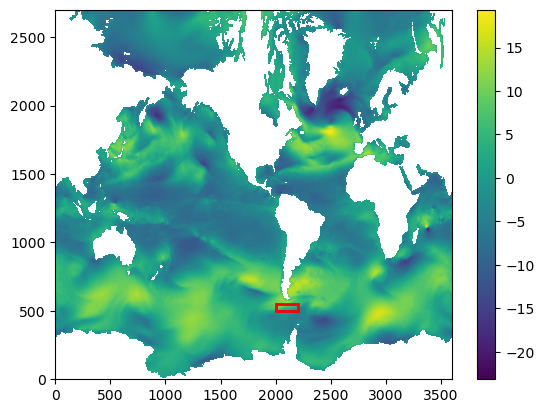

In [12]:
# Extract the data for the specific region
data = ds_in.u_ref.isel(time=0)

# Plot the data using pcolor
plt.pcolor(data, cmap='viridis')

# Get the bounds of the region (using the indices)
x_min, x_max = 2000, 2200
y_min, y_max = 500, 550

# Draw a rectangle around the region (the coordinates are based on the index positions)
rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)  # Add the rectangle to the current axes

# Show the plot
plt.colorbar()
plt.show()


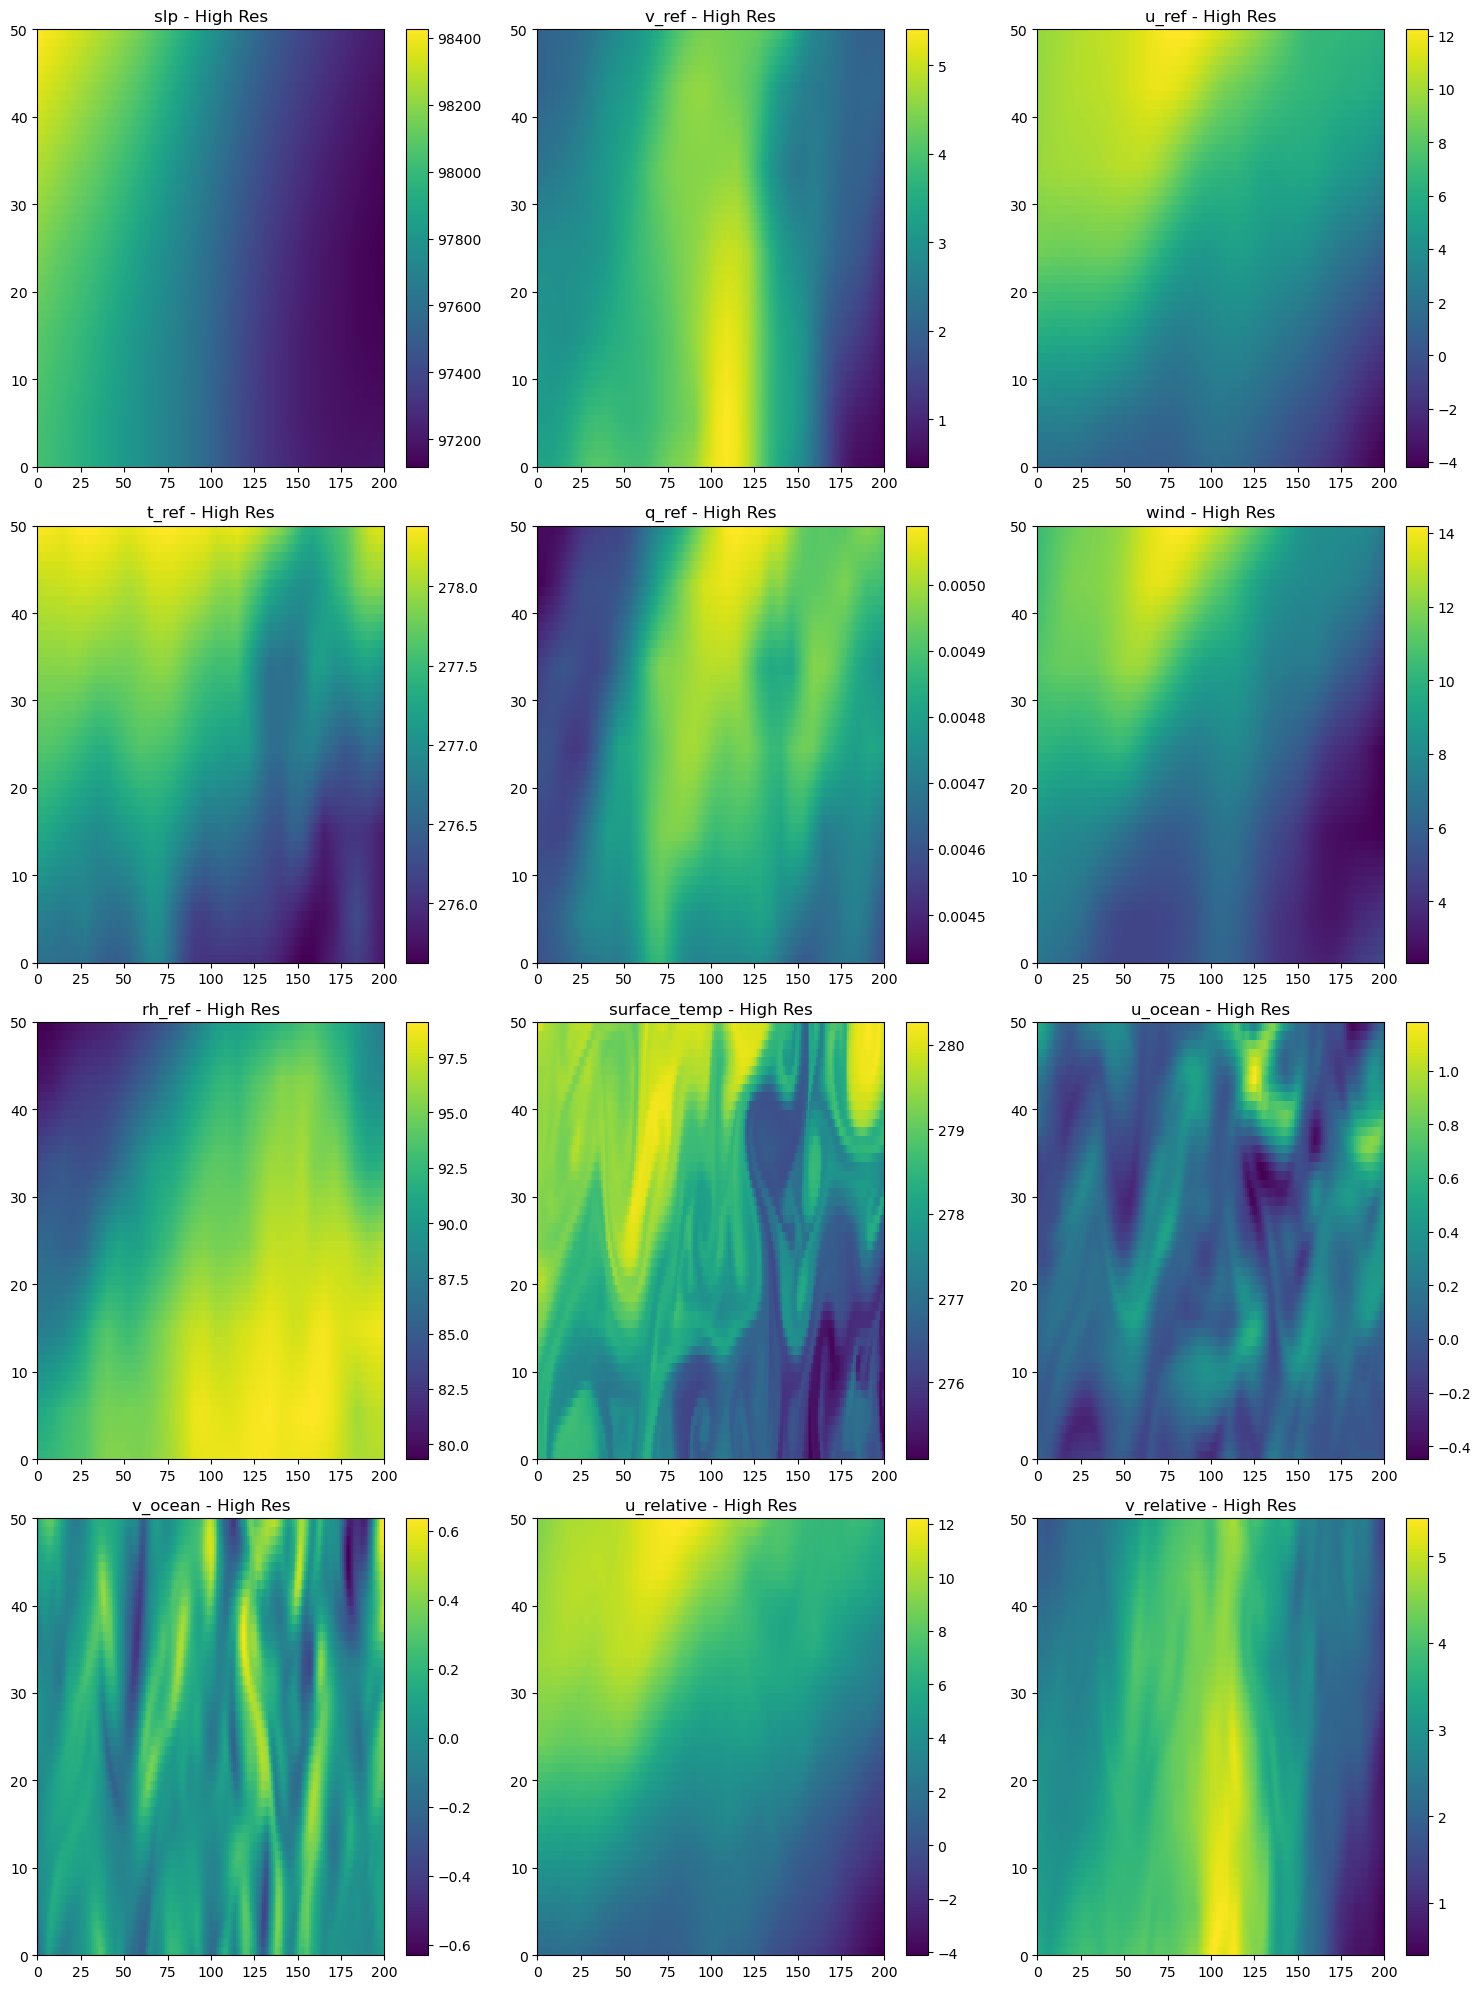

In [11]:
# Plot HR data for each variable

# Assuming variables is a list with 12 variables, e.g., variables = ['var1', 'var2', ..., 'var12']
# And data_high_res is a dictionary with high-resolution data for each variable

fig, axs = plt.subplots(4, 3, figsize=(15, 20))

for i, var in enumerate(variables):
    row = i // 3  # Calculate row index (integer division by 3)
    col = i % 3   # Calculate column index (remainder when divided by 3)
    
    high_res = data_high_res[var]  # Get high-res data for current variable

    # High-resolution plot
    im1 = axs[row, col].pcolor(high_res, cmap='viridis')
    axs[row, col].set_title(f"{var} - High Res")
    plt.colorbar(im1, ax=axs[row, col])

# Adjust layout for readability
plt.tight_layout()
plt.show()


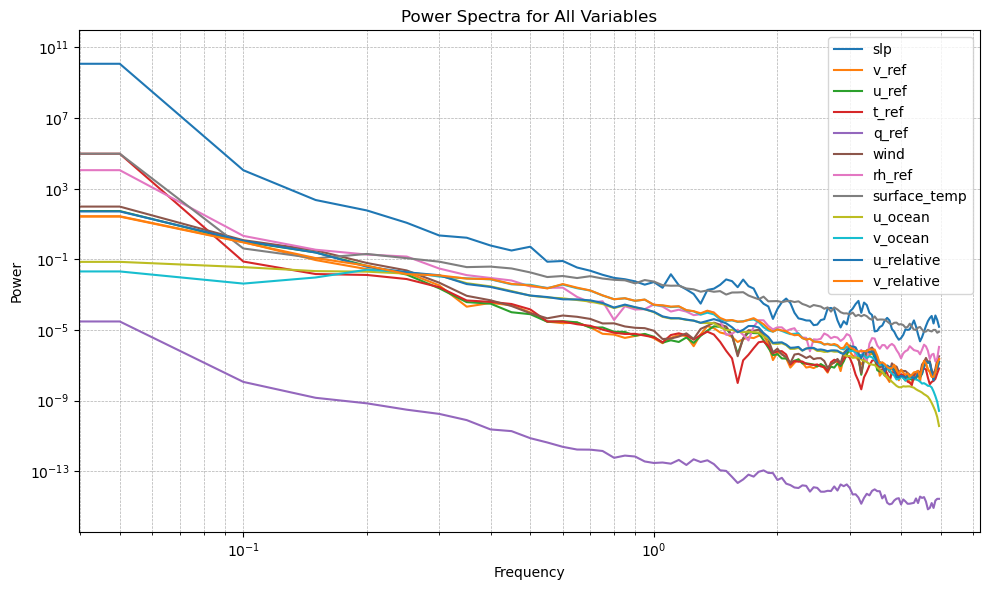

In [9]:
import xrft

# Create a single figure
plt.figure(figsize=(10, 6))

# Loop through each variable to compute and plot its power spectrum
for var in variables:
    high_res = data_high_res[var]  # Extract high-res data for the variable

    # Compute power spectrum
    ps = xrft.power_spectrum(high_res, dim='xt_ocean', window=True).mean(dim='yt_ocean')

    # Plot power spectrum
    plt.plot(ps.freq_xt_ocean, ps, label=var)  # Use variable name as label

# Configure the plot
plt.title("Power Spectra for All Variables")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')  # Add legend to differentiate variables
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()


In [8]:
from PIL import Image
import os

data_HR_thruTime = ds_in.isel(xt_ocean=slice(2000,2200), yt_ocean=slice(500,550))

# Example plotting function for high-resolution (HR) data only
def plot_fun(idt, var): 
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the high-resolution data
    data_HR_thruTime[var].isel(time=idt).plot(ax=ax, x='xt_ocean', y='yt_ocean', cmap='viridis', robust=True)
    ax.set_title(f'High Res {var} - Frame {idt}')

# Animation creation function remains unchanged
def create_animation(fun, idx, var, filename='my-animation.gif', dpi=200, FPS=18, loop=0):
    frames = []
    for i in idx:
        fun(i, var)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

# Call the animation creation for HR data only
create_animation(plot_fun, range(0, 30), "slp", 'HR_slp_animation.gif', dpi=100, FPS=8)


Animation at FPS=8 will last for 3.75 seconds


In [9]:
create_animation(plot_fun, range(0, 30), "v_ref", 'HR_vref_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "u_ref", 'HR_uref_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "t_ref", 'HR_tref_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "q_ref", 'HR_qref_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "wind", 'HR_wind_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "rh_ref", 'HR_rhref_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "surface_temp", 'HR_sst_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "u_ocean", 'HR_uocean_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "v_ocean", 'HR_vocean_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "u_relative", 'HR_urel_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "v_relative", 'HR_vrel_animation.gif', dpi=100, FPS=8)

Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds


## Pacific Ocean case

In [25]:
variables = ["slp", "v_ref", "u_ref", "t_ref", "q_ref", "wind", "rh_ref", 
             "surface_temp", "u_ocean", "v_ocean", "u_relative", "v_relative"]

data_high_res = ds_in.isel(time=0, xt_ocean=slice(700,1300), yt_ocean=slice(1500,1800))
data_low_res = ds_out.isel(time=0, xt_ocean=slice(700,1300), yt_ocean=slice(1500,1800))

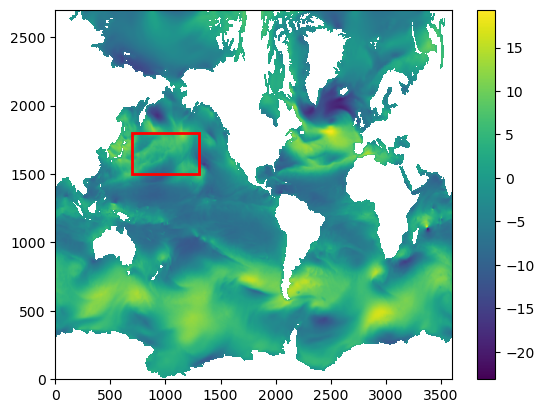

In [26]:
# Extract the data for the specific region
data = ds_in.u_ref.isel(time=0)

# Plot the data using pcolor
plt.pcolor(data, cmap='viridis')

# Get the bounds of the region (using the indices)
x_min, x_max = 700, 1300
y_min, y_max = 1500, 1800

# Draw a rectangle around the region (the coordinates are based on the index positions)
rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect)  # Add the rectangle to the current axes

# Show the plot
plt.colorbar()
plt.show()


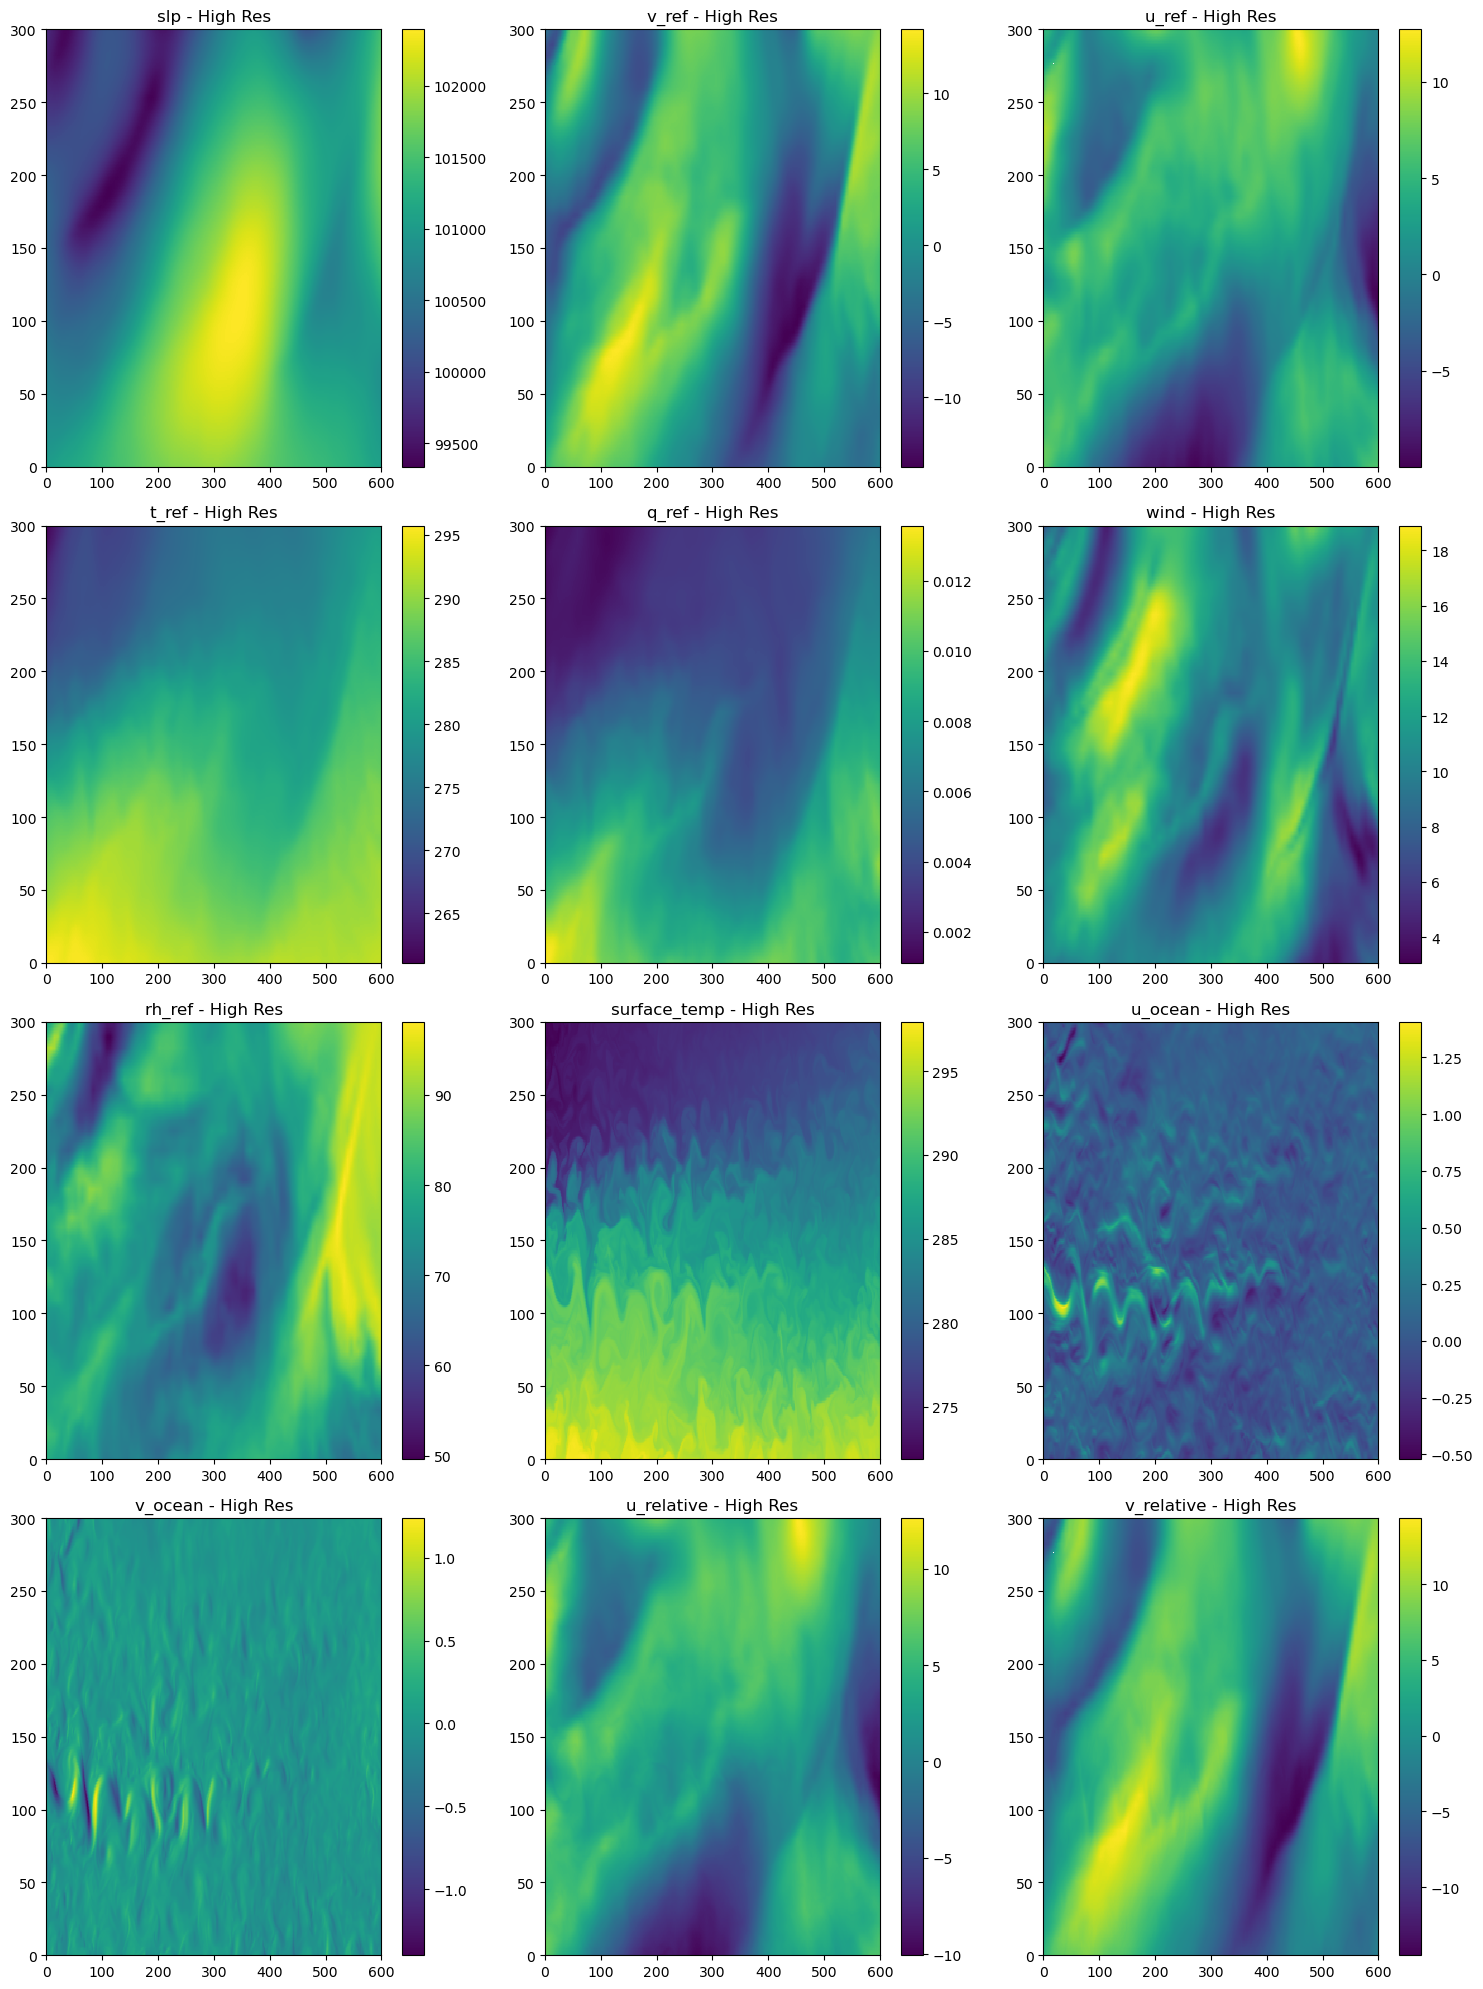

In [27]:
# Plot HR data for each variable

# Assuming variables is a list with 12 variables, e.g., variables = ['var1', 'var2', ..., 'var12']
# And data_high_res is a dictionary with high-resolution data for each variable

fig, axs = plt.subplots(4, 3, figsize=(15, 20))

for i, var in enumerate(variables):
    row = i // 3  # Calculate row index (integer division by 3)
    col = i % 3   # Calculate column index (remainder when divided by 3)
    
    high_res = data_high_res[var]  # Get high-res data for current variable

    # High-resolution plot
    im1 = axs[row, col].pcolor(high_res, cmap='viridis')
    axs[row, col].set_title(f"{var} - High Res")
    plt.colorbar(im1, ax=axs[row, col])

# Adjust layout for readability
plt.tight_layout()
plt.show()


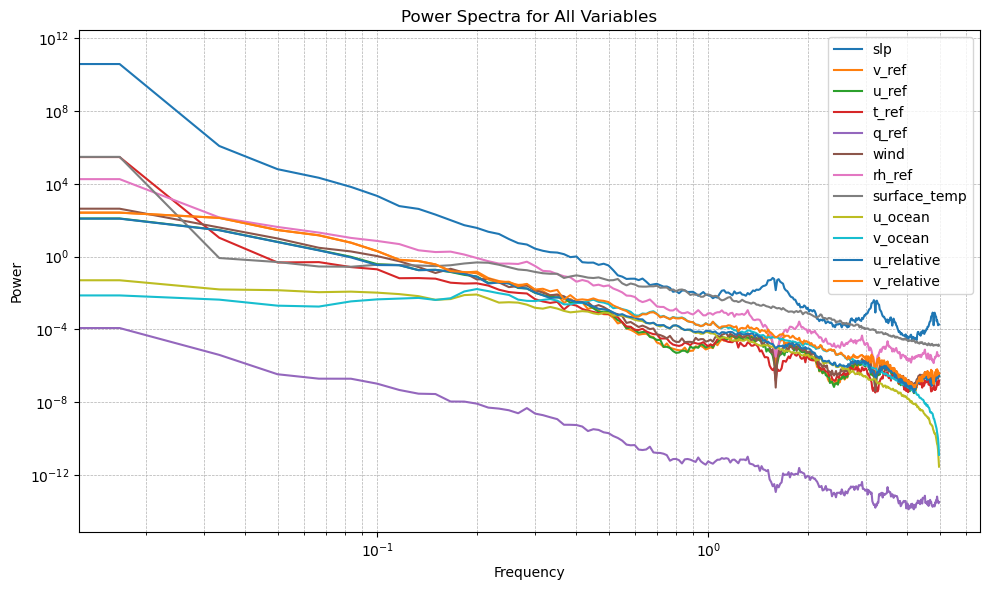

In [28]:
import xrft

# Create a single figure
plt.figure(figsize=(10, 6))

# Loop through each variable to compute and plot its power spectrum
for var in variables:
    high_res = data_high_res[var]  # Extract high-res data for the variable

    # Compute power spectrum
    ps = xrft.power_spectrum(high_res, dim='xt_ocean', window=True).mean(dim='yt_ocean')

    # Plot power spectrum
    plt.plot(ps.freq_xt_ocean, ps, label=var)  # Use variable name as label

# Configure the plot
plt.title("Power Spectra for All Variables")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')  # Add legend to differentiate variables
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()


In [29]:
from PIL import Image
import os

data_HR_thruTime = ds_in.isel(xt_ocean=slice(700,1300), yt_ocean=slice(1500,1800))

# Example plotting function for high-resolution (HR) data only
def plot_fun(idt, var): 
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the high-resolution data
    data_HR_thruTime[var].isel(time=idt).plot(ax=ax, x='xt_ocean', y='yt_ocean', cmap='viridis', robust=True)
    ax.set_title(f'High Res {var} - Frame {idt}')

# Animation creation function remains unchanged
def create_animation(fun, idx, var, filename='my-animation.gif', dpi=200, FPS=18, loop=0):
    frames = []
    for i in idx:
        fun(i, var)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

# Call the animation creation for HR data only
create_animation(plot_fun, range(0, 30), "slp", 'pacific_HR_slp_animation.gif', dpi=100, FPS=8)


Animation at FPS=8 will last for 3.75 seconds


In [30]:
create_animation(plot_fun, range(0, 30), "v_ref", 'pacific_HR_vref_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "u_ref", 'pacific_HR_uref_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "t_ref", 'pacific_HR_tref_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "q_ref", 'pacific_HR_qref_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "wind", 'pacific_HR_wind_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "rh_ref", 'pacific_HR_rhref_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "surface_temp", 'pacific_HR_sst_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "u_ocean", 'pacific_HR_uocean_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "v_ocean", 'pacific_HR_vocean_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "u_relative", 'pacific_HR_urel_animation.gif', dpi=100, FPS=8)
create_animation(plot_fun, range(0, 30), "v_relative", 'pacific_HR_vrel_animation.gif', dpi=100, FPS=8)

Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
Animation at FPS=8 will last for 3.75 seconds
